<a href="https://colab.research.google.com/github/Lisker2/ML/blob/main/Project/ProteinBert_A_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/nadavbra/shared_utils.git
!git clone https://github.com/nadavbra/protein_bert
!pip install protein-bert

Cloning into 'shared_utils'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 48 (delta 26), reused 37 (delta 15), pack-reused 0
Unpacking objects: 100% (48/48), 22.66 KiB | 859.00 KiB/s, done.
Cloning into 'protein_bert'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 206 (delta 52), reused 66 (delta 40), pack-reused 121
Receiving objects: 100% (206/206), 23.43 MiB | 31.69 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [29]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs
from proteinbert import load_pretrained_model

In [4]:
train = pd.read_csv('protein_bert/protein_benchmarks/stability.train.csv')[:2000]
valid = pd.read_csv('protein_bert/protein_benchmarks/stability.valid.csv')[:300]
test = pd.read_csv('protein_bert/protein_benchmarks/stability.test.csv')[:300]

train_X = train['seq']
valid_X = valid['seq']
test_X = test['seq']

In [5]:
train_Y = train['label']
valid_Y = valid['label']
test_Y = test['label']

In [6]:
train.head()

,seq,label
0,DQSVRKLVRKLPDEGLDREKVKTYLDKLGVDREELQKFSDAIGLES...,-0.21
1,GSSDIEITVEGKEQADKVIEEMKRRNLEVHVEEHNGQYIDKASLES...,-0.95
2,GSSTERRTFDDETQARKAAEEAKKKGLQVTVTKENGQYHVDFN,0.42
3,MLDDFTHELMLDDFTHELMLDDFTHELMLDDFTHELSSNGGGSNGS...,0.10
4,GSSTQTITTTNKENAEQIAREAKKKGLDVTIRKNNGTWEIHWD,0.76


In [7]:
sequence_length = max(train.seq.map(lambda x: len(x)).max(), 
             test.seq.map(lambda x: len(x)).max(), 
             valid.seq.map(lambda x: len(x)).max()) + 2
print('sequence_length', sequence_length)

sequence_length 52


In [8]:
pretrained_model_generator, input_encoder = load_pretrained_model("/content/")

 Local model dump file /content/default.pkl doesn't exist. Will download ftp://ftp.cs.huji.ac.il/users/nadavb/protein_bert/epoch_92400_sample_23500000.pkl into /content/. Please approve or reject this (to exit and potentially call the function again with different parameters).
Do you approve downloadig the file into the specified directory? Please specify "Yes" or "No":yes
Downloaded file: /content/epoch_92400_sample_23500000.pkl
Created: /content/default.pkl


In [9]:
print(type(train_X))
print(train_X.shape)

<class 'pandas.core.series.Series'>
(2000,)


In [10]:
train_X = input_encoder.encode_X(train_X, sequence_length)
valid_X = input_encoder.encode_X(valid_X, sequence_length)
test_X = input_encoder.encode_X(test_X, sequence_length)

In [11]:
model_generator = get_model_with_hidden_layers_as_outputs(pretrained_model_generator.create_model(sequence_length))

In [12]:
local_representations_train, global_representations_train= model_generator.predict(train_X, batch_size = 64)
local_representations_valid, global_representations_valid= model_generator.predict(valid_X, batch_size = 64)
local_representations_test, global_representations_test= model_generator.predict(test_X, batch_size = 64)

5/5 [==============================] - 0s 69ms/step


In [18]:
model_stability = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = local_representations_train[0].shape),
    tf.keras.layers.Dense(1, activation = 'linear')]
)
model_stability.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mse'])
training_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-05, verbose = 1),
    tf.keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]
history_stability = model_stability.fit(local_representations_train, train_Y, 
                                validation_data=(local_representations_valid, valid_Y), 
                                batch_size=64, epochs=30,
                                callbacks=training_callbacks)

Epoch 1/30
32/32 [==============================] - 1s 15ms/step - loss: 2.2681 - mse: 2.2681 - val_loss: 0.9886 - val_mse: 0.9886 - lr: 0.0010
Epoch 2/30
32/32 [==============================] - 0s 9ms/step - loss: 0.3475 - mse: 0.3475 - val_loss: 0.2877 - val_mse: 0.2877 - lr: 0.0010
Epoch 3/30
32/32 [==============================] - 0s 8ms/step - loss: 0.2093 - mse: 0.2093 - val_loss: 0.2776 - val_mse: 0.2776 - lr: 0.0010
Epoch 4/30
31/32 [============================>.] - ETA: 0s - loss: 0.1659 - mse: 0.1659
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
32/32 [==============================] - 0s 9ms/step - loss: 0.1653 - mse: 0.1653 - val_loss: 0.3156 - val_mse: 0.3156 - lr: 0.0010
Epoch 5/30
32/32 [==============================] - 0s 8ms/step - loss: 0.1347 - mse: 0.1347 - val_loss: 0.2578 - val_mse: 0.2578 - lr: 2.5000e-04
Epoch 6/30
25/32 [======================>.......] - ETA: 0s - loss: 0.1213 - mse: 0.1213
Epoch 6: ReduceLROnPlateau reducing l

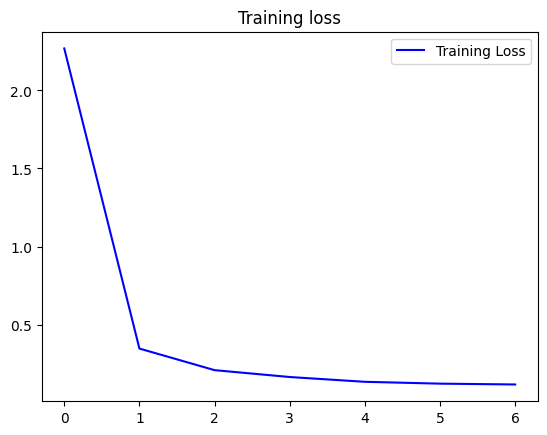

In [28]:
loss = history_stability.history['loss']

plt.plot(range(len(loss)), loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

In [33]:
predict_Y = model_stability.predict(local_representations_test)
p, _ = spearmanr(predict_Y, test_Y)
print(p)

10/10 [==============================] - 0s 2ms/step
0.6226134309809512
